#FB Prophet implementation

**Summary**


**Data**: WTI Crude Oil price

**Granularity**: monthly data

**Source**: FRED

**Time period**: 1986-01-01 / 2022-01-01

**Model**: FB Prophet


# Importing Libraries

In [ ]:
# Install Prophet library
!pip install prophet

# Required packages
import pandas as pd
import numpy as np
import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# To plot data
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import seaborn as sns
sns.set()

# Load the data

In [4]:
file_path = "/content/MCOILWTICO.csv"
data = pd.read_csv(file_path)
data.DATE = pd.to_datetime(data.DATE)
data.set_index("DATE", inplace = True)

In [5]:
# Define log returns as a new variable
log_returns = np.log(data["MCOILWTICO"]).diff(1) 
data["log_returns"] = log_returns 

In [6]:
# Filter the dataset
data = data[["log_returns", "MCOILWTICO"]]



# Train-Test Split

In [7]:
train_df = data.loc[:"2016-12-31"]
test_df = data.loc["2017-01-01":]
print(train_df.shape)
print(test_df.shape)

(372, 2)
(61, 2)


# Prophet

##Prophet - Log Returns

### Data processing

In [8]:
#Reshape the dataset for fitting a Prophet model
returns_df = pd.DataFrame(columns = ["ds", "y"])
returns_df["ds"] = data.index
returns_df["y"] = data["log_returns"].values

In [9]:
returns_train_df = pd.DataFrame(columns = ["ds", "y"])
returns_train_df["ds"] = train_df.index
returns_train_df["y"] = train_df["log_returns"].values

In [10]:
returns_test_df = pd.DataFrame(columns = ["ds", "y"])
returns_test_df["ds"] = test_df.index
returns_test_df["y"] = test_df["log_returns"].values

### Fitting Model

In [ ]:
returns_model = Prophet()
returns_model.fit(returns_train_df)

### Making Predictions on the test set


In [12]:
future_df = returns_model.make_future_dataframe(periods=len(returns_test_df.index), freq = "M")

In [13]:
returns_predictions_df = returns_model.predict(future_df)

In [14]:
#Visualize predictions results
returns_predictions_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1986-01-01,0.003715,-0.091383,0.119317,0.003715,0.003715,0.011746,0.011746,0.011746,0.011746,0.011746,0.011746,0.0,0.0,0.0,0.015461
1,1986-02-01,0.003715,-0.131381,0.086565,0.003715,0.003715,-0.023834,-0.023834,-0.023834,-0.023834,-0.023834,-0.023834,0.0,0.0,0.0,-0.020119
2,1986-03-01,0.003715,-0.083172,0.133829,0.003715,0.003715,0.022374,0.022374,0.022374,0.022374,0.022374,0.022374,0.0,0.0,0.0,0.026089
3,1986-04-01,0.003715,-0.076494,0.133451,0.003715,0.003715,0.027378,0.027378,0.027378,0.027378,0.027378,0.027378,0.0,0.0,0.0,0.031093
4,1986-05-01,0.003716,-0.089530,0.129941,0.003716,0.003716,0.016077,0.016077,0.016077,0.016077,0.016077,0.016077,0.0,0.0,0.0,0.019793


### Plotting Forecasts and components

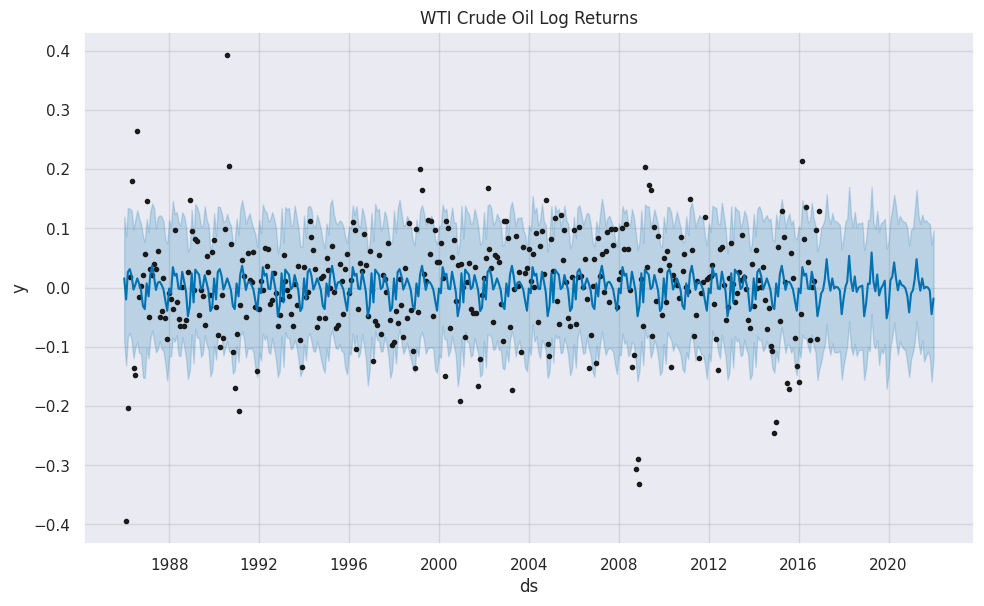

In [15]:
#Plot the returns
returns_model.plot(returns_predictions_df)
plt.title("WTI Crude Oil Log Returns")
plt.show()

In [16]:
# Interactive plot
plot_plotly(returns_model, returns_predictions_df)

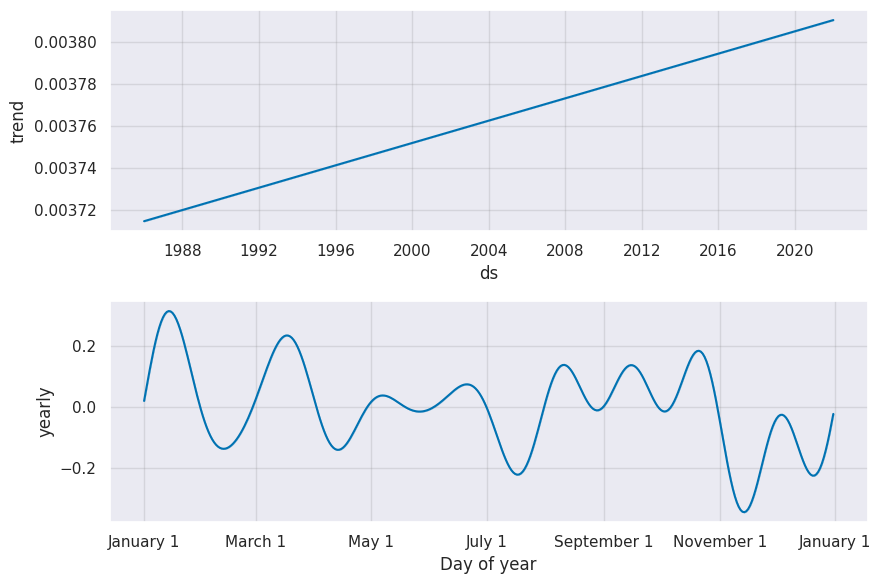

In [17]:
#Plot model components
returns_model.plot_components(returns_predictions_df)
plt.show()

The overall trend is increasing as shown in the first plot. Though, we observe some fluctuation during the year, especially with peaks around january and april, whereas returns drop at the end of november.

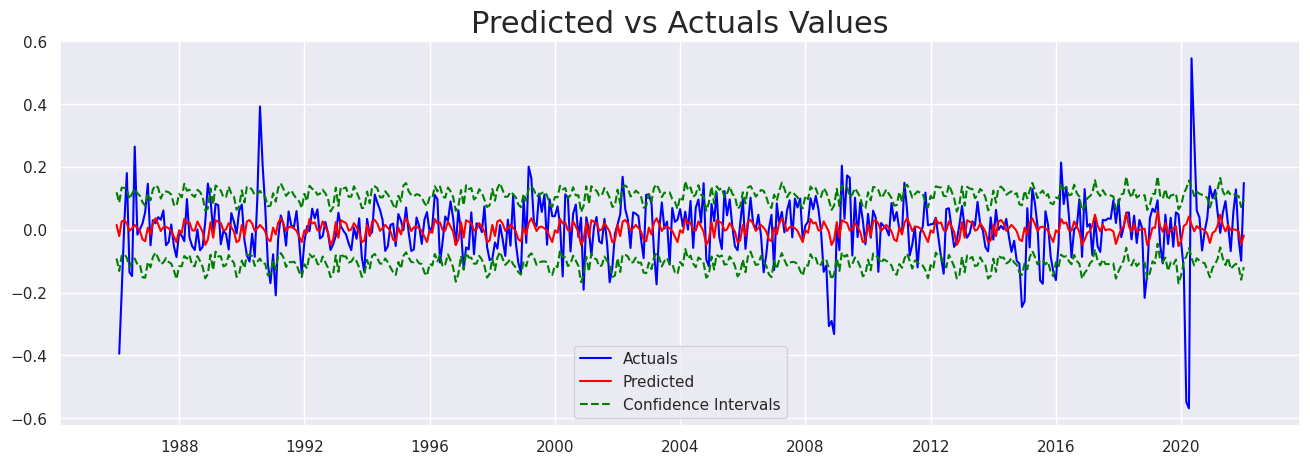

In [18]:
plt.rcParams["figure.figsize"] = 16, 5

plt.plot(data["log_returns"], color = "blue", label = "Actuals")
plt.plot(data.index, returns_predictions_df["yhat"], color = "red", label = "Predicted")
plt.plot(data.index, returns_predictions_df["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(data.index, returns_predictions_df["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Values", size = 22)
plt.legend()
plt.show()

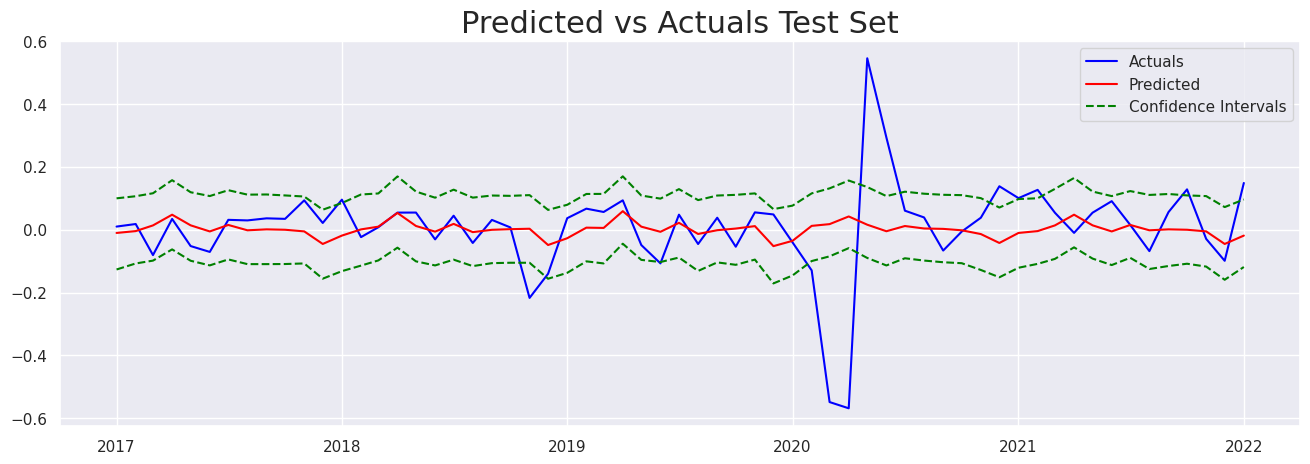

In [19]:
plt.rcParams["figure.figsize"] = 16, 5

plt.plot(test_df["log_returns"], color = "blue", label = "Actuals")
plt.plot(test_df.index, returns_predictions_df.loc[returns_train_df.index[-1]+1:]["yhat"], color = "red", label = "Predicted")
plt.plot(test_df.index, returns_predictions_df.loc[returns_train_df.index[-1]+1:]["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(test_df.index, returns_predictions_df.loc[returns_train_df.index[-1]+1:]["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Test Set", size = 22)
plt.legend()
plt.show()

In general, Prophet model is able to capture the movements of returns apart from 

### Get the RMSE

In [20]:
#Get the RMSE
y_true = returns_test_df["y"].values
y_pred = returns_predictions_df["yhat"][-len(returns_test_df.index):].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

RMSE: 0.1505872271120753


## Prophet - Adj Close 

### Data processing

In [21]:
prices_df = pd.DataFrame(columns = ["ds", "y"])
prices_df["ds"] = data.index
prices_df["y"] = data["MCOILWTICO"].values

In [22]:
prices_train_df = pd.DataFrame(columns = ["ds", "y"])
prices_train_df["ds"] = train_df.index
prices_train_df["y"] = train_df["MCOILWTICO"].values

In [23]:
prices_test_df = pd.DataFrame(columns = ["ds", "y"])
prices_test_df["ds"] = test_df.index
prices_test_df["y"] = test_df["MCOILWTICO"].values

### Fitting Model

In [24]:
prices_model = Prophet()
prices_model.fit(prices_train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdl8cky76/g5dk9wpm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdl8cky76/6f900d5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45690', 'data', 'file=/tmp/tmpdl8cky76/g5dk9wpm.json', 'init=/tmp/tmpdl8cky76/6f900d5g.json', 'output', 'file=/tmp/tmpdl8cky76/prophet_modelqq35rq9q/prophet_model-20230529212028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Making Predictions

In [25]:
future_df = prices_model.make_future_dataframe(periods=len(prices_test_df.index), freq = "M")

In [26]:
prices_predictions_df = prices_model.predict(future_df)

In [27]:
#Visualize predictions results
prices_predictions_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1986-01-01,16.806358,-1.303205,33.227266,16.806358,16.806358,-1.463117,-1.463117,-1.463117,-1.463117,-1.463117,-1.463117,0.0,0.0,0.0,15.343241
1,1986-02-01,16.834551,-1.401002,32.057653,16.834551,16.834551,-2.128855,-2.128855,-2.128855,-2.128855,-2.128855,-2.128855,0.0,0.0,0.0,14.705697
2,1986-03-01,16.860016,-1.288281,31.617962,16.860016,16.860016,-0.875923,-0.875923,-0.875923,-0.875923,-0.875923,-0.875923,0.0,0.0,0.0,15.984093
3,1986-04-01,16.888209,0.994332,33.688962,16.888209,16.888209,0.847393,0.847393,0.847393,0.847393,0.847393,0.847393,0.0,0.0,0.0,17.735602
4,1986-05-01,16.915493,2.181243,35.445976,16.915493,16.915493,1.160457,1.160457,1.160457,1.160457,1.160457,1.160457,0.0,0.0,0.0,18.075950


### Plotting Forecasts and components

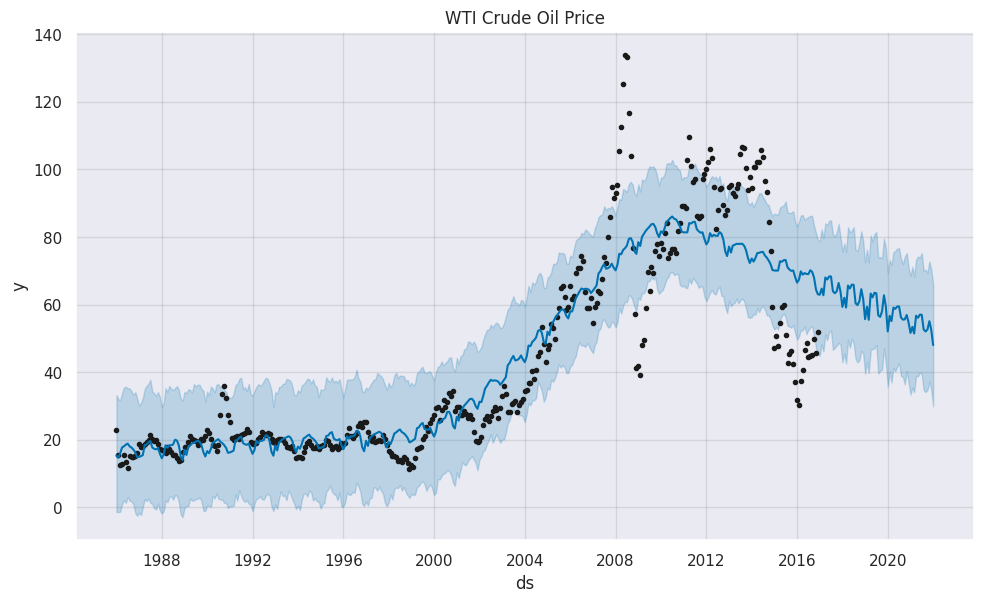

In [28]:
prices_model.plot(prices_predictions_df)
plt.title('WTI Crude Oil Price')
plt.show()

In [29]:
# Interactive plot
plot_plotly(prices_model, prices_predictions_df)

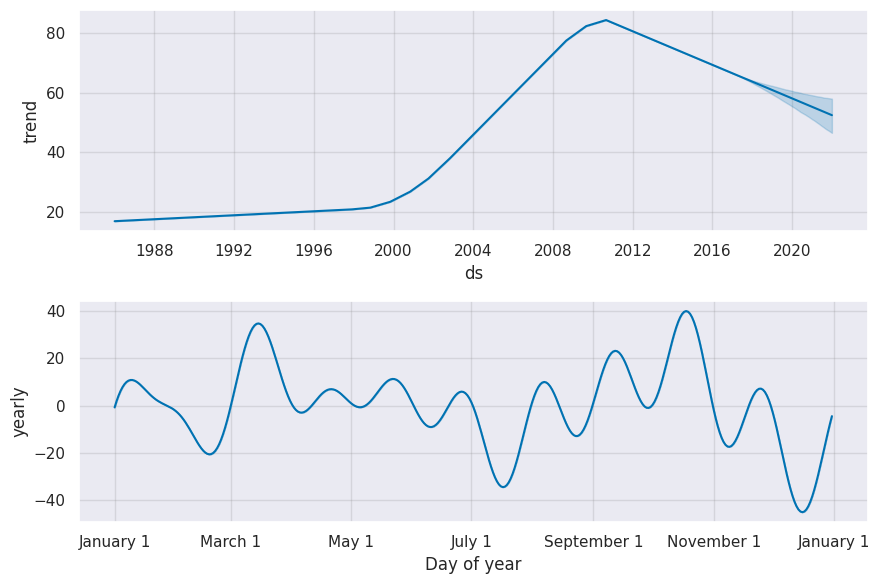

In [30]:
prices_model.plot_components(prices_predictions_df)
plt.show()

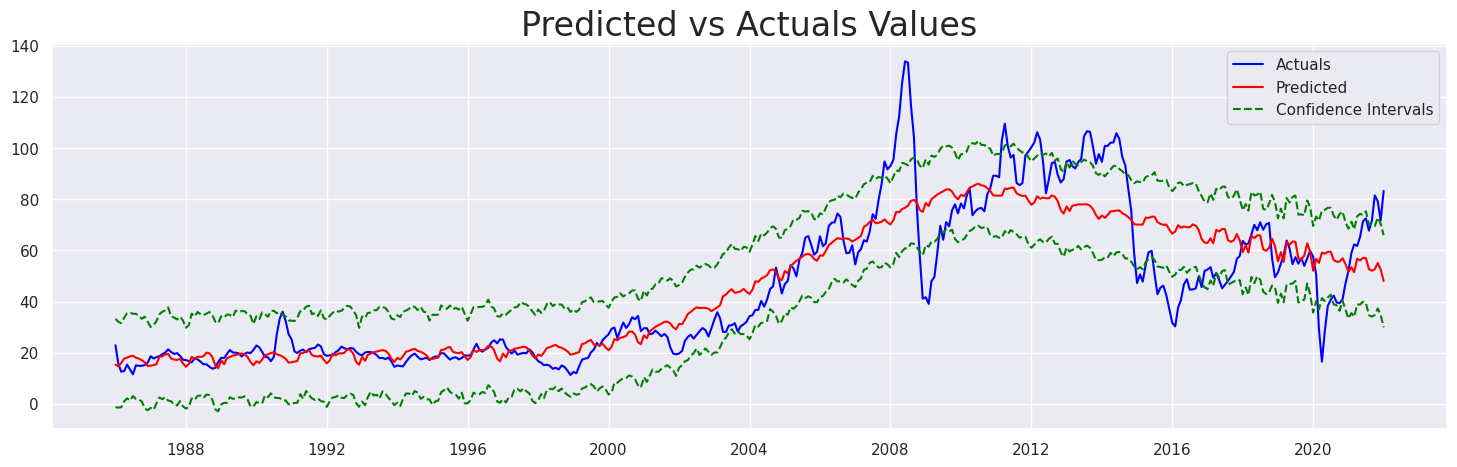

In [31]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(data["MCOILWTICO"], color = "blue", label = "Actuals")
plt.plot(data.index, prices_predictions_df["yhat"], color = "red", label = "Predicted")
plt.plot(data.index, prices_predictions_df["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(data.index, prices_predictions_df["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Values", size = 24)
plt.legend()
plt.show()

In 2009, there was indeed a significant shock in the WTI (West Texas Intermediate) oil price. The global financial crisis that started in 2008 had a profound impact on various markets, including the oil market.

During this period, the WTI oil price experienced a sharp decline, reaching its lowest point in February 2009. This decline was primarily driven by the decrease in global demand for oil due to the economic downturn and reduced industrial activity. The financial crisis led to a contraction in the global economy, resulting in a decrease in oil consumption. As shown in the plot above, around 2009 we observe a peak in oil price followed by a huge drop, thus making it difficult for Prophet to capture such unexpected variation.

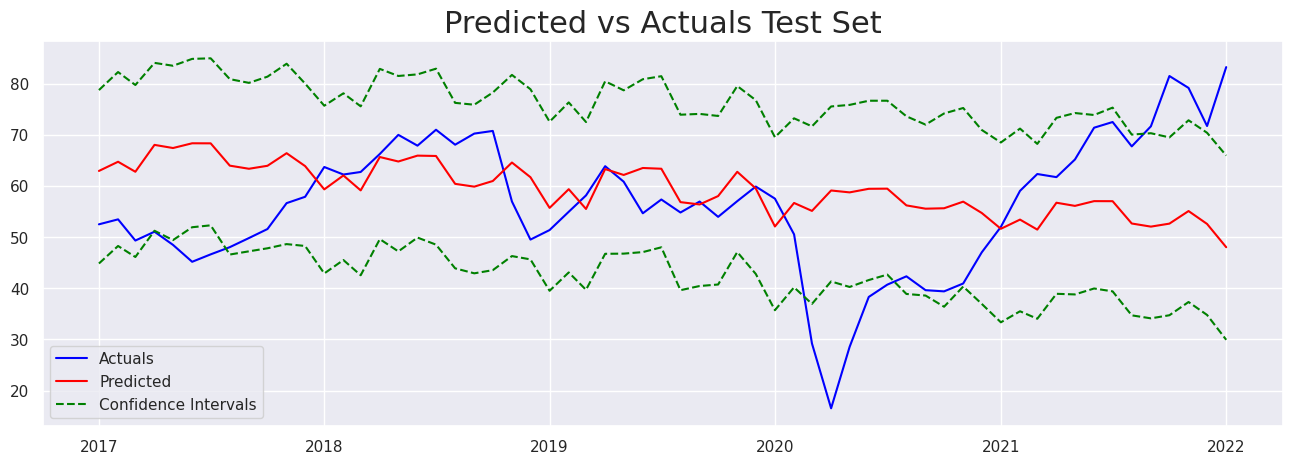

In [32]:
plt.rcParams["figure.figsize"] = 16, 5

plt.plot(test_df["MCOILWTICO"], color = "blue", label = "Actuals")
plt.plot(test_df.index, prices_predictions_df.loc[prices_train_df.index[-1]+1:]["yhat"], color = "red", label = "Predicted")
plt.plot(test_df.index, prices_predictions_df.loc[prices_train_df.index[-1]+1:]["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(test_df.index, prices_predictions_df.loc[prices_train_df.index[-1]+1:]["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Test Set", size = 22)
plt.legend()
plt.show()

In 2020, worldwide demand for oil fell rapidly as governments closed businesses and restricted travel due to the COVID-19 pandemic. In this situation, the price of Oil per barrel plunged for a while.

### Get the RMSE

In [33]:
y_true = prices_test_df["y"].values
y_pred = prices_predictions_df["yhat"][-len(prices_test_df.index):].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

RMSE: 14.6967757486141


### Conclusion
In this notebook, FB Prophet is used to investigate log returns and adjusted prices of WTI Crude Oil, the US benchmark. Despite several shocks along the oil history, due to financial crisis, war and demand/supply shocks, Prophet is quite able to capture the trend of both returns and prices, making of course some errors in periods of great changes and instability.